Unsure so far what file types I'll principally be dealing with. Here's a list of the file types on TCGA:
- .maf files: 
- .vcf files:

## Calculating some TMBs

In [3]:
install.packages("tidyverse")
library(tidyverse)




The downloaded binary packages are in
	/var/folders/g9/9x6m35fn5ydf88vdlm9n1vg80000gn/T//RtmpxeRzQg/downloaded_packages


In [4]:
if (!requireNamespace("BiocManager"))
    install.packages("BiocManager")
BiocManager::install()
library(BiocManager)

Bioconductor version 3.8 (BiocManager 1.30.3), R 3.5.1 (2018-07-02)
Update old packages: 'foreign', 'lattice', 'MASS', 'Matrix', 'mgcv', 'survival'


Import relevant packages: tidyverse for data handling, biocmanager for bioinformatics

In [5]:
setwd("/Users/jacobbradley/Documents/CCG")

In [41]:
new_data <- read_tsv("/Volumes/CCG8/processed_data/brca_tcga/data_mutations_extended.txt")

Warning message:
“Missing column names filled in: 'X54' [54]”Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  stop_WU = col_integer(),
  X54 = col_double(),
  tumor_vaf = col_double(),
  normal_ref_reads = col_integer(),
  start_WU = col_integer(),
  strand_WU = col_integer(),
  tumors_var_reads = col_integer(),
  normal_vaf = col_double(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3282 parsing failures.
row # A tibble: 5 x 5 col     row col     expected  actual file                                         

Get data of the CCG USB stick

In [42]:
new_data_abridged <- new_data %>% 
    select(Chromosome, Start_Position, End_Position, Strand, Consequence, Variant_Classification, Variant_Type, Reference_Allele, Tumor_Seq_Allele1, Tumor_Seq_Allele2, Tumor_Sample_Barcode, Matched_Norm_Sample_Barcode, Score, Codons, tumor_vaf)

Get rid of data columns that are unnecessary/I don't yet understand

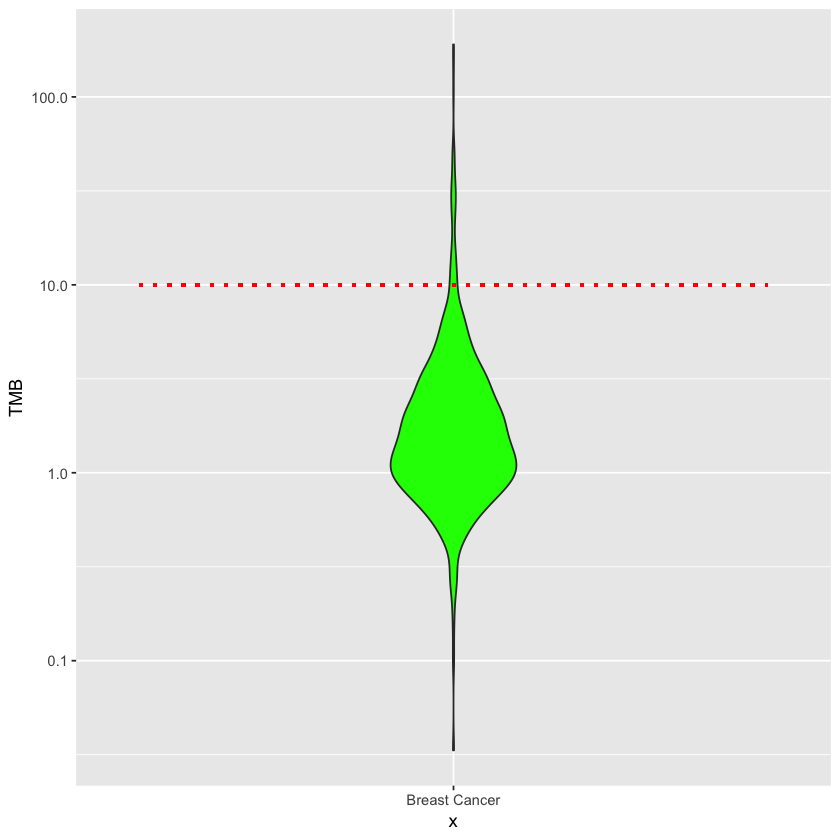

In [43]:
new_data_abridged %>% 
    group_by(Tumor_Sample_Barcode) %>% 
    summarise(TMB = n()/30) %>% 
    ggplot(aes(x = "Breast Cancer", y = TMB)) + 
    geom_violin(width = 0.2, fill = "green") + 
    scale_y_log10() + geom_segment(aes(x = 0.5, 
    y = 10, xend = 1.5, yend = 10), colour = "red",
    linetype = "dotted", size = 1)

### Function for TMB calculation

In [562]:
TMB_Calc <- function(maf_file) {
# Takes a maf file and outputs a table with tumor sample barcode and TMB value
# Requires tidyverse to be installed
    data_abridged <- maf_file %>% 
        select('Hugo_Symbol', one_of(c('Start_Position','Start_position')), one_of(c('End_Position','End_position')), Strand, Variant_Classification, Variant_Type, Reference_Allele, Tumor_Seq_Allele1, Tumor_Seq_Allele2, Tumor_Sample_Barcode,  Score) %>% 
        filter(Variant_Classification %in% c('Frame_Shift_Del', 'Frame_Shift_Ins', 'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation', 'Nonsense_Mutation', 'Nonstop_Mutation', 'Splice_Site', 'Translation_Start_Site'))
    
    tmb_table <-  data_abridged %>% 
                distinct() %>% 
                group_by(Tumor_Sample_Barcode) %>% 
                summarise(TMB = n()/30)
    return(tmb_table)
}

Make a nice plot of our (very rudimentary) TMB calculation for that study!

In [44]:
path_name = "/Volumes/CCG8/processed_data"

In [46]:
for (i in 1:length(dir(path_name))) {
    if (!("data_mutations_extended.txt" %in% dir(paste0(path_name, "/", dir(path_name)[i])))) {
        print(paste0("Their is no mutations file in ", dir(path_name)[i]))
    }
}

[1] "Their is no mutations file in archived_files"
[1] "Their is no mutations file in brafresist"
[1] "Their is no mutations file in case_lists"
[1] "Their is no mutations file in prad_mskcc_2014"
[1] "Their is no mutations file in sarc_mskcc"


Work out what files don't have a mutations folder

## Attempting to do that across several studies (without blowing up my computer)

In [487]:
tmb_table <- tibble(Tumor_Sample_Barcode = character(), TMB = vector(), study = character(), cancer_type = character())

for (i in 1:length(dir(path_name))) {
#for (i in 1:10) {  #replace with line above if this works well
    if ("data_mutations_extended.txt" %in% dir(paste0(path_name, "/", dir(path_name)[i]))) {
        print(dir(path_name)[i])
        study_meta <- read_tsv(paste0(path_name, "/", dir(path_name)[i], "/meta_study.txt"), col_names = FALSE)
        cancer <- substr(study_meta[1,],17,nchar((study_meta[1,])))
        print(cancer)
        new_data <- read_tsv(paste0(path_name, "/", dir(path_name)[i], "/data_mutations_extended.txt"))
        if (substr(colnames(new_data),1,1)[1] == '#') {
            new_data <- read_tsv(paste0(path_name, "/", dir(path_name)[i], "/data_mutations_extended.txt"), skip = 1)
        }
        if (substr(colnames(new_data),1,1)[1] == '#') {
            new_data <- read_tsv(paste0(path_name, "/", dir(path_name)[i], "/data_mutations_extended.txt"), skip = 2)
        }
        new_data$Tumor_Sample_Barcode <- as.character(new_data$Tumor_Sample_Barcode)
        new_data_abridged <- new_data %>% 
            select(Chromosome, one_of('Hugo_Symbol', c('Start_Position','Start_position')), one_of(c('End_Position','End_position')), Strand, Variant_Classification, Variant_Type, Reference_Allele, Tumor_Seq_Allele1, Tumor_Seq_Allele2, Tumor_Sample_Barcode,  Score)
        new_tmb_table <- new_data_abridged %>%
            distinct() %>% 
            group_by(Tumor_Sample_Barcode) %>% 
            summarise(TMB = n()/30, study = dir(path_name)[i], cancer_type = cancer)
        tmb_table <- bind_rows(tmb_table, new_tmb_table)
    }
}

[1] "acbc_mskcc_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "acbc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "acc_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "acc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  TVarCov = col_integer(),
  Trna_ref = col_integer(),
  NTotCov = col_integer(),
  Trna_var = col_integer(),
  NVarCov = col_integer(),
  Trna_alt1 = col_integer(),
  Trna_alt2 = col_integer(),
  Trna_tot = col_integer(),
  TTotCov = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "acc_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "acc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "acyc_fmi_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "acyc"


Parsed with column specification:
cols(
  `#sequenced_samples: ACYC-FMI-14 ACYC-FMI-15 ACYC-FMI-16 ACYC-FMI-17 ACYC-FMI-10 ACYC-FMI-11 ACYC-FMI-12 ACYC-FMI-13 ACYC-FMI-18 ACYC-FMI-19 ACYC-FMI-28 ACYC-FMI-21 ACYC-FMI-20 ACYC-FMI-23 ACYC-FMI-22 ACYC-FMI-25 ACYC-FMI-24 ACYC-FMI-27 ACYC-FMI-26 ACYC-FMI-07 ACYC-FMI-06 ACYC-FMI-05 ACYC-FMI-04 ACYC-FMI-03 ACYC-FMI-02 ACYC-FMI-01 ACYC-FMI-09 ACYC-FMI-08` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“30 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 50 colum… '/Volumes/CCG8/processed_data/acyc_fmi_2014/… file 2     2 <NA>  1 columns 50 colum… '/Volumes/CCG8/processed_data/acyc_fmi_2014/… row 3     3 <NA>  1 columns 50 colum… '/Volumes/CCG8/

[1] "acyc_mda_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "acyc"


Parsed with column specification:
cols(
  `#sequenced_samples: ACYC-MDA_AC01 ACYC-MDA_AC02 ACYC-MDA_AC03 ACYC-MDA_AC04 ACYC-MDA_AC05 ACYC-MDA_AC06 ACYC-MDA_AC07 ACYC-MDA_AC08 ACYC-MDA_AC09 ACYC-MDA_AC10 ACYC-MDA_AC11 ACYC-MDA_AC12 ACYC-MDA_AC13 ACYC-MDA_AC14 ACYC-MDA_AC15 ACYC-MDA_AC16 ACYC-MDA_AC17 ACYC-MDA_AC18 ACYC-MDA_AC19 ACYC-MDA_AC20 ACYC-MDA_AC21 ACYC-MDA_AC22 ACYC-MDA_AC23 ACYC-MDA_AC24 ACYC-MDA_AC25 ACYC-MDA_AC26 ACYC-MDA_AC27 ACYC-MDA_AC28 ACYC-MDA_AC29 ACYC-MDA_AC30 ACYC-MDA_AC31 ACYC-MDA_AC32 ACYC-MDA_AC33 ACYC-MDA_AC34 ACYC-MDA_AC35 ACYC-MDA_AC36 ACYC-MDA_AC37 ACYC-MDA_AC38 ACYC-MDA_AC39 ACYC-MDA_AC40 ACYC-MDA_AC41 ACYC-MDA_AC42 ACYC-MDA_AC43 ACYC-MDA_AC44 ACYC-MDA_AC45 ACYC-MDA_AC46 ACYC-MDA_AC47 ACYC-MDA_AC48 ACYC-MDA_AC49 ACYC-MDA_AC50 ACYC-MDA_AC51 ACYC-MDA_AC52 ACYC-MDA_AC53 ACYC-MDA_AC54 ACYC-MDA_AC67 ACYC-MDA_AC68 ACYC-MDA_AC69 ACYC-MDA_AC70 ACYC-MDA_AC71 ACYC-MDA_AC72 ACYC-MDA_AC73 ACYC-MDA_AC74 ACYC-MDA_AC77 ACYC-MDA_AC78 ACYC-MDA_AC79` = col_character()
)
Warnin

[1] "acyc_mskcc_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "acyc"


Parsed with column specification:
cols(
  `#sequenced_samples: ACYC-MSKCC_000609 ACYC-MSKCC_006536 ACYC-MSKCC_001346 ACYC-MSKCC_000705 ACYC-MSKCC_131169 ACYC-MSKCC_007441 ACYC-MSKCC_002128 ACYC-MSKCC_000236 ACYC-MSKCC_001947 ACYC-MSKCC_142990 ACYC-MSKCC_000505 ACYC-MSKCC_001781 ACYC-MSKCC_002039 ACYC-MSKCC_007136 ACYC-MSKCC_002238 ACYC-MSKCC_002012 ACYC-MSKCC_002237 ACYC-MSKCC_000479 ACYC-MSKCC_000410 ACYC-MSKCC_002020 ACYC-MSKCC_122891 ACYC-MSKCC_065115 ACYC-MSKCC_007097 ACYC-MSKCC_118135 ACYC-MSKCC_111097 ACYC-MSKCC_000540 ACYC-MSKCC_001739 ACYC-MSKCC_128229 ACYC-MSKCC_065103 ACYC-MSKCC_002282 ACYC-MSKCC_000380 ACYC-MSKCC_2453 ACYC-MSKCC_3492 ACYC-MSKCC_4133 ACYC-MSKCC_4332 ACYC-MSKCC_6112 ACYC-MSKCC_6277 ACYC-MSKCC_9534 ACYC-MSKCC_80872 ACYC-MSKCC_148632 ACYC-MSKCC_671204 ACYC-MSKCC_980452 ACYC-MSKCC_990149 ACYC-MSKCC_2000120 ACYC-MSKCC_2000136 ACYC-MSKCC_2000756 ACYC-MSKCC_36773720 ACYC-MSKCC_05_6986 ACYC-MSKCC_06_2532 ACYC-MSKCC_07_16582 ACYC-MSKCC_09_12352 ACYC-MSKCC_09_4178 ACYC

[1] "acyc_sanger_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "acyc"


Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“311 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual   file                                          expected   <int> <chr> <chr>      <chr>    <chr>                                         actual 1     1 <NA>  24 columns 50 colu… '/Volumes/CCG8/processed_data/acyc_sanger_20… file 2     2 <NA>  24 columns 50 colu… '/Volumes/CCG8/processed_data/acyc_sanger_20… row 3     3 <NA>  24 columns 50 colu… '/Volumes/CCG8/processed_data/acyc_sanger_20… col 4     4 <NA>  24 columns 50 colu… '/Volumes/CCG8/processed_data/acyc_sanger_20… expected 5     5 <NA>  24 columns 50 colu… '/Volumes/CCG8/processed_data/acyc_sanger_20…
... ................. ... ........................................................................

[1] "all_phase2_target_2018_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "bll"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "all_stjude_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "all_stjude_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "bll"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "all_stjude_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "bll"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  `Total Reads Tumor` = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "aml_target_2018_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "aml"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ampca_bcm_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ampca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "angs_project_painter_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "angs"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  NCBI_Build = col_integer(),
  Start_position = col_integer(),
  End_position = col_integer(),
  Transcript_Exon = col_integer(),
  Transcript_Position = col_integer(),
  UniProt_AApos = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  gc_content = col_double(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  i_1000gp3_AC = col_integer(),
  i_1000gp3_AF = col_double(),
  i_1000gp3_AFR_AF = col_double(),
  i_1000gp3_AMR_AF = col_double(),
  i_1000gp3_AN = col_integer(),
  i_1000gp3_DP = col_integer(),
  i_1000gp3_EAS_AF = col_double(),
  i_1000gp3_EUR_AF = col_double(),
  i_1000gp3_NS = col_integer(),
  i_1000gp3_SAS_AF = col_double()
  # ... with 59 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“78 pars

[1] "bfn_duke_nus_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "bfn"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  `Total Read Depth` = col_integer(),
  `Variant Read Depth` = col_integer(),
  `Variant Allele Frequency (%)` = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "blca_bgi"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "blca_dfarber_mskcc_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  `#sequenced_samples: DFCI-21_NR DFCI-26_R DFCI-29_R DFCI-31_NR DFCI-32_R DFCI-33_NR DFCI-34_NR DFCI-35_R DFCI-37_R DFCI-38_NR DFCI-43_NR DFCI-04_R DFCI-05_R DFCI-06_R DFCI-07_R DFCI-09_NR MSKCC-0007_NR MSKCC-0100_R MSKCC-0101_NR MSKCC-0231_R MSKCC-0234_NR MSKCC-0243_NR MSKCC-0255_NR MSKCC-0279_NR MSKCC-0296_R MSKCC-0301_NR MSKCC-0331_NR MSKCC-0343_R MSKCC-0373_NR MSKCC-0389_R MSKCC-0411_R MSKCC-0425_R MSKCC-0439_NR MSKCC-0445_R MSKCC-0446_R MSKCC-0450_NR MSKCC-0464_R MSKCC-0500_R MSKCC-0547_R MSKCC-0567_NR MSKCC-0620_R MSKCC-0651_NR MSKCC-0677_R MSKCC-0730_NR MSKCC-0741_R MSKCC-0745_NR MSKCC-0754_NR MSKCC-0760_NR MSKCC-0820_NR MSKCC-0821_R` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“21366 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <ch

[1] "blca_mskcc_solit_2012"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "blca_mskcc_solit_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "blca_nmibc_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "blca_plasmacytoid_mskcc_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "blca_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  qox = col_double(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_double(),
  isArtifactMode = col_double(),
  pox = col_double(),
  gc_content = col_double(),
  pox_cutoff = col_double(),
  oxoGCut = col_double()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“565 parsing failures.
row # A tibble: 5 x 5 col     row col      expected actual             file                               expected   <int> <chr>    <chr>    <chr>              <chr>                             

[1] "blca_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "blca_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "blca_tcga_pub_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "blca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Match_Norm_Seq_Allele1 = col_double(),
  Match_Norm_Seq_Allele2 = col_double(),
  Tumor_Validation_Allele1 = col_double(),
  Tumor_Validation_Allele2 = col_double(),
  Match_Norm_Validation_Allele1 = col_double(),
  Match_Norm_Validation_Allele2 = col_double(),
  Verification_Status = col_double(),
  Validation_Status = col_double(),
  Score = col_double(),
  BAM_File = col_double(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  i_init_t_lod = col_double(),
  i_ESP_GWAS_PUBMED = col_double()
  # ... with 62 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“5191

[1] "brca_bccrc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“2398 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/brca_bccrc/dat… file 2     2 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/brca_bccrc/dat… row 3     3 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/brca_bccrc/dat… col 4     4 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/brca_bccrc/dat… expected 5     5 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/brca_bccrc/dat…
... ................. ... ............................................................................... ........ ......................

[1] "brca_bccrc_xenograft_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  `MA:FIS` = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "brca_broad"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“4986 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/brca_broad/dat… file 2     2 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/brca_broad/dat… row 3     3 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/brca_broad/dat… col 4     4 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/brca_broad/dat… expected 5     5 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/brca_broad/dat…
... ................. ... ............................................................................... ........ ......................

[1] "brca_igr_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Freq_Variant_Allele_Normal = col_double(),
  Freq_Variant_Allele_Tumor = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "brca_mbcproject_wagle_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  NCBI_Build = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Transcript_Exon = col_integer(),
  Transcript_Position = col_integer(),
  UniProt_AApos = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  gc_content = col_double(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  i_1000gp3_AC = col_integer(),
  i_1000gp3_AF = col_double(),
  i_1000gp3_AFR_AF = col_double(),
  i_1000gp3_AMR_AF = col_double(),
  i_1000gp3_AN = col_integer(),
  i_1000gp3_DP = col_integer(),
  i_1000gp3_EAS_AF = col_double(),
  i_1000gp3_EUR_AF = col_double(),
  i_1000gp3_NS = col_integer(),
  i_1000gp3_SAS_AF = col_double()
  # ... with 60 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“1384 pa

[1] "brca_metabric"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“17273 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual   file                                          expected   <int> <chr> <chr>      <chr>    <chr>                                         actual 1     1 <NA>  32 columns 45 colu… '/Volumes/CCG8/processed_data/brca_metabric/… file 2     2 <NA>  32 columns 45 

[1] "brca_sanger"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "brca_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Warning message:
“Missing column names filled in: 'X54' [54]”Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  stop_WU = col_integer(),
  X54 = col_double(),
  tumor_vaf = col_double(),
  normal_ref_reads = col_integer(),
  start_WU = col_integer(),
  strand_WU = col_integer(),
  tumors_var_reads = col_integer(),
  normal_vaf = col_double(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3282 parsing failures.
row # A tibble: 5 x 5 col     row col     expected  actual file                                         

[1] "brca_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "brca_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ALLELE_NUM = col_integer(),
  PICK = col_integer(),
  n_depth = col_integer(),
  HGNC_ID = col_integer(),
  ExAC_AF_AMR = col_double(),
  t_depth = col_integer(),
  `MA:FIS` = col_double(),
  DISTANCE = col_integer(),
  ExAC_AF_SAS = col_double(),
  GENE_PHENO = col_integer(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_NFE = col_double(),
  stop_wu = col_integer(),
  stop_WU = col_integer()
  # ... with 11 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“42 parsing failures.
row # A tibble: 5 x 5 col     row col      expected        actual file                                    expect

[1] "brca_tcga_pub2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "brca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ALLELE_NUM = col_integer(),
  AA_MAF = col_double(),
  ASN_MAF = col_double(),
  AFR_MAF = col_double(),
  EA_MAF = col_double(),
  PUBMED = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“30 parsing failures.
row # A tibble: 5 x 5 col     row col    expected      actual                file                         expected   <int> <chr>  <chr>         <chr>                 <chr>                        actual 1  4642 PUBMED no trailing … ,132,864,314,508,700  '/Volumes/CCG8/processed_

[1] "breast_msk_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "breast"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ccrcc_irc_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ccrcc"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "ccrcc_utokyo_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ccrcc"


Warning message:
“Duplicated column names deduplicated: 'End_Position' => 'End_Position_1' [118]”Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  n_depth = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_NFE = col_double(),
  ExAC_AF_SAS = col_double()
  # ... with 1 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“2997 parsing failures.
row # A tibble

[1] "cellline_ccle_broad"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  `MA:FIS` = col_double(),
  ONCOTATOR_PROTEIN_POS_END = col_integer(),
  ONCOTATOR_PROTEIN_POS_END_BEST_EFFECT = col_integer(),
  ONCOTATOR_EXON_AFFECTED = col_integer(),
  MA = col_integer(),
  ONCOTATOR_PROTEIN_POS_START = col_integer(),
  ONCOTATOR_EXON_AFFECTED_BEST_EFFECT = col_integer(),
  ONCOTATOR_PROTEIN_POS_START_BEST_EFFECT = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“2898 parsing failures.
row # A tibble: 5 x 5 col     row col      expected  actual file                                          expec

[1] "cellline_nci60"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“74151 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/cellline_nci60… file 2     2 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/cellline_nci60… row 3     3 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/cellline_nci60… col 4     4 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/cellline_nci60… expected 5     5 <NA>  1 columns 143 colu… '/Volumes/CCG8/processed_data/cellline_nci60…
... ................. ... ............................................................................... ........ .....................

[1] "cesc_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "cesc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  n_ref_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  tumor_vaf = col_double(),
  `MA:FIS` = col_double(),
  ONCOTATOR_PROTEIN_POS_END = col_integer(),
  stop = col_integer(),
  ONCOTATOR_PROTEIN_POS_END_BEST_EFFECT = col_integer(),
  ONCOTATOR_EXON_AFFECTED = col_integer(),
  ONCOTATOR_PROTEIN_POS_START = col_integer(),
  n_var_count = col_integer(),
  ONCOTATOR_EXON_AFFECTED_BEST_EFFECT = col_integer(),
  t_var_count = col_integer(),
  start = col_integer(),
  normal_vaf = col_double(),
  ONCOTATOR_PROTEIN_POS_START_BEST_EFFECT = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "cesc_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "cesc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“5509 parsing failures.
row # A tibble: 5 x 5 col     row col      expected  actual file                                          expected   <int> <chr>    <chr>     <chr>  <chr>                                         actual 1 19355 Chromos… an integ… X      '/Volumes/CCG8/processed_data/cesc_tcga_pan_… file 2 19356 Chromos… an integ… X      '

[1] "chol_jhu_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "chol"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  n_depth = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PUBMED = col_integer(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double(),
  ExAC_AF_NFE = col_double()
  # ... with 3 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3 parsing failures.
row # A tibble: 3 x 5 col     row col    expected       actual          file                              expected   <

[1] "chol_nccs_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "chol"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“244 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 145 colu… '/Volumes/CCG8/processed_data/chol_nccs_2013… file 2     2 <NA>  1 columns 145 colu… '/Volumes/CCG8/processed_data/chol_nccs_2013… row 3     3 <NA>  1 columns 145 colu… '/Volumes/CCG8/processed_data/chol_nccs_2013… col 4     4 <NA>  1 columns 145 colu… '/Volumes/CCG8/processed_data/chol_nccs_2013… expected 5     5 <NA>  1 columns 145 colu… '/Volumes/CCG8/processed_data/chol_nccs_2013…
... ................. ... ............................................................................... ........ .......................

[1] "chol_nus_2012"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "chol"


Warning message:
“Missing column names filled in: 'X37' [37]”Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  `MA:FIS` = col_double(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "chol_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "chol"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  TTotCov_SOL = col_integer(),
  NTotCov_SOL = col_integer(),
  TVarCov_SOL = col_integer(),
  NVarCov_SOL = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "chol_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "chol"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "cll_iuopa_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "cllsll"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknow

[1] "cllsll_icgc_2011"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "cllsll"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "coad_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "coad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "coadread_dfci_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "coadread"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer(),
  `MA:FIS` = col_double()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“325 parsing failures.
row # A tibble: 5 x 5 col      row col    expected  actual                 file                           expected    <int> <chr>  <chr>     <chr>                  <chr>                          actual 1 188444 t_dep… an integ… R609C                  '/Volumes/CCG8/processed_data… file 2 188444 MA:FIS a double  getma.org/?cm=var&var… '/Volumes/CCG8/processed_data… row 3 188445 t_dep… an integ… L322F                  '/Volumes/CCG8/processed_data… col 4 188445 MA:FIS a doubl

[1] "coadread_genentech"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "coadread"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“36272 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 144 colu… '/Volumes/CCG8/processed_data/coadread_genen… file 2     2 <NA>  1 columns 144 colu… '/Volumes/CCG8/processed_data/coadread_genen… row 3     3 <NA>  1 columns 144 colu… '/Volumes/CCG8/processed_data/coadread_genen… col 4     4 <NA>  1 columns 144 colu… '/Volumes/CCG8/processed_data/coadread_genen… expected 5     5 <NA>  1 columns 144 colu… '/Volumes/CCG8/processed_data/coadread_genen…
... ................. ... ............................................................................... ........ .....................

[1] "coadread_mskcc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "coadread"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "coadread_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "coadread"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "coadread_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "coadread"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer(),
  `MA:FIS` = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "crc_msk_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "coadread"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_positi

[1] "cscc_dfarber_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "cscc"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  i_COSMIC_n_overlapping_mutations = col_

[1] "cscc_hgsc_bcm_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "cscc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  COSMIC_Gene_Freq = col_integer(),
  TAlleleFrac = col_double(),
  NAlleleFrac = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“125 parsing failures.
row # A tibble: 5 x 5 col     row col      expected        actual file                                    expected   <int> <chr>    <chr>           <chr>  <chr>                                   actual 1  1558 NAllele… no trailing ch… .02    '/Volumes/CCG8/processed_data/cscc_hgs… file 2  2096 NAllele… no trailing ch… .01    '/Volumes/CCG8/processed_data/cscc_hgs… row 3  3803 NAllele… no trailing ch… .01    '/Volumes/CCG8/proces

[1] "ctcl_columbia_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nhl"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "desm_broad_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "desm"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "dlbc_broad_2012"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nhl"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "dlbc_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "dlbcl"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  TVarCov = col_double(),
  NTotCov = col_double(),
  NVarCov = col_double(),
  TVarRat = col_double(),
  TTotCov = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "dlbc_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "dlbclnos"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "dlbcl_duke_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "dlbclnos"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  observed_in_TN_pair = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "egc_msk_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "egc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "egc_tmucih_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "egc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  n_depth = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double(),
  ExAC_AF_NFE = col_double(),
  ExAC_AF_OTH = col_double()
  # ... with 4 more columns
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "es_dfarber_broad_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "es"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknow

[1] "es_iocurie_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "es"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ProteinGI = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "esca_broad"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "esca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ALLELE_NUM = col_integer(),
  PICK = col_integer(),
  Transcript_Exon = col_integer(),
  n_depth = col_integer(),
  HGNC_ID = col_integer(),
  ExAC_AF_AMR = col_double(),
  t_depth = col_integer(),
  `MA:FIS` = col_double(),
  DISTANCE = col_integer(),
  ExAC_AF_SAS = col_double(),
  GENE_PHENO = col_integer(),
  ExAC_AF_AFR = col_double(),
  Allelic_fraction = col_double()
  # ... with 9 more columns
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "esca_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "esca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  normal_VAF = col_double(),
  tumor_var_reads = col_integer(),
  normal_ref_reads = col_integer(),
  stop = col_integer(),
  tumor_VAF = col_double(),
  start = col_integer(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "esca_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "esca"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "escc_icgc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "escc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_depth = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PUBMED = col_number(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double()
  # ... with 7 more columns
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "escc_ucla_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "escc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  n_depth = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double(),
  ExAC_AF_NFE = col_double(),
  ExAC_AF_OTH = col_double()
  # ... with 2 more columns
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "gbc_shanghai_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "gbc"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“5266 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 166 colu… '/Volumes/CCG8/processed_data/gbc_shanghai_2… file 2     2 <NA>  1 columns 166 colu… '/Volumes/CCG8/processed_data/gbc_shanghai_2… row 3     3 <NA>  1 columns 166 colu… '/Volumes/CCG8/processed_data/gbc_shanghai_2… col 4     4 <NA>  1 columns 166 colu… '/Volumes/CCG8/processed_data/gbc_shanghai_2… expected 5     5 <NA>  1 columns 166 colu… '/Volumes/CCG8/processed_data/gbc_shanghai_2…
... ................. ... ............................................................................... ........ ......................

[1] "gbm_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "gbm"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  UniProt_AApos = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  gc_content = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "gbm_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "gbm"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "gbm_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "gbm"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  n_depth = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PUBMED = col_number(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double(),
  ExAC_AF_NFE = col_double()
  # ... with 3 more columns
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "gbm_tcga_pub2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "gbm"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“15600 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 282 colu… '/Volumes/CCG8/processed_data/gbm_tcga_pub20… file 2     2 <NA>  1 columns 282 colu… '/Volumes/CCG8/processed_data/gbm_tcga_pub20… row 3     3 <NA>  1 columns 282 colu… '/Volumes/CCG8/processed_data/gbm_tcga_pub20… col 4     4 <NA>  1 columns 282 colu… '/Volumes/CCG8/processed_data/gbm_tcga_pub20… expected 5     5 <NA>  1 columns 282 colu… '/Volumes/CCG8/processed_data/gbm_tcga_pub20…
... ................. ... ............................................................................... ........ .....................

[1] "gct_msk_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "gct"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "hcc_inserm_fr_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "hnc_mskcc_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“1391 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 116 colu… '/Volumes/CCG8/processed_data/hnc_mskcc_2016… file 2     2 <NA>  1 columns 116 colu… '/Volumes/CCG8/processed_data/hnc_mskcc_2016… row 3     3 <NA>  1 columns 116 colu… '/Volumes/CCG8/processed_data/hnc_mskcc_2016… col 4     4 <NA>  1 columns 116 colu… '/Volumes/CCG8/processed_data/hnc_mskcc_2016… expected 5     5 <NA>  1 columns 116 colu… '/Volumes/CCG8/processed_data/hnc_mskcc_2016…
... ................. ... ............................................................................... ........ ......................

[1] "hnsc_broad"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hnsc"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“9604 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 136 colu… '/Volumes/CCG8/processed_data/hnsc_broad/dat… file 2     2 <NA>  1 columns 136 colu… '/Volumes/CCG8/processed_data/hnsc_broad/dat… row 3     3 <NA>  1 columns 136 colu… '/Volumes/CCG8/processed_data/hnsc_broad/dat… col 4     4 <NA>  1 columns 136 colu… '/Volumes/CCG8/processed_data/hnsc_broad/dat… expected 5     5 <NA>  1 columns 136 colu… '/Volumes/CCG8/processed_data/hnsc_broad/dat…
... ................. ... ............................................................................... ........ ......................

[1] "hnsc_jhu"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hnsc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ONCOTATOR_EXON_AFFECTED = col_integer(),
  `MA:FIS` = col_double(),
  ONCOTATOR_PROTEIN_POS_START = col_integer(),
  ONCOTATOR_PROTEIN_POS_END = col_integer(),
  ONCOTATOR_EXON_AFFECTED_BEST_EFFECT = col_integer(),
  ONCOTATOR_PROTEIN_POS_START_BEST_EFFECT = col_integer(),
  ONCOTATOR_PROTEIN_POS_END_BEST_EFFECT = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "hnsc_mdanderson_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hnsc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "hnsc_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hnsc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  qox = col_double(),
  isArtifactMode = col_integer(),
  pox = col_double(),
  gc_content = col_double(),
  UniProt_AApos = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  pox_cutoff = col_double(),
  oxoGCut = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "hnsc_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hnsc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "hnsc_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hnsc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ALLELE_NUM = col_integer(),
  PICK = col_integer(),
  HGNC_ID = col_integer(),
  ExAC_AF_AMR = col_double(),
  `MA:FIS` = col_double(),
  DISTANCE = col_integer(),
  ExAC_AF_SAS = col_double(),
  GENE_PHENO = col_integer(),
  ExAC_AF_NFE = col_double(),
  COSMIC_total_alterations_in_gene = col_integer(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF = col_double(),
  ExAC_AF_OTH = col_double()
  # ... with 11 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“29 parsing failures.
row # A tibble: 5 x 5 col     row col    expected       actual             

[1] "kich_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "chrcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "kich_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "chrcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "kich_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "chrcc"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "kirc_bgi"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ccrcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "kirc_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ccrcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "kirc_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ccrcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "kirc_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ccrcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ALLELE_NUM = col_integer(),
  PICK = col_integer(),
  n_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "kirp_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  TVarCov = col_double(),
  NTotCov = col_double(),
  NVarCov = col_double(),
  TTotCov = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "kirp_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "laml_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "aml"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NormalRefReads_WU = col_integer(),
  NormalVarReads_WU = col_integer(),
  TumorRefReads_WU = col_integer(),
  RNAVAF_WU = col_double(),
  RNAVarReads_WU = col_integer(),
  stop = col_integer(),
  NormalVAF_WU = col_double(),
  start = col_integer(),
  TumorVarReads_WU = col_integer(),
  TumorVAF_WU = col_double(),
  RNARefReads_WU = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "laml_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "aml"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ALLELE_NUM = col_integer(),
  PICK = col_integer(),
  n_depth = col_integer(),
  HGNC_ID = col_integer(),
  ExAC_AF_AMR = col_double(),
  t_depth = col_integer(),
  DISTANCE = col_integer(),
  ExAC_AF_SAS = col_double(),
  GENE_PHENO = col_integer(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_NFE = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double(),
  HGVS_OFFSET = col_integer()
  # ... with 4 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“132200 parsing failures.
row # A tibble: 5 x 5 col     row col     expected      actual              file                   

[1] "laml_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "aml"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  normalvaf_wu = col_double(),
  n_depth = col_integer(),
  RNAVAF_WU = col_double(),
  t_depth = col_integer(),
  RNAVarReads_WU = col_integer(),
  normalvarreads_wu = col_integer(),
  tumorrefreads_wu = col_integer(),
  rnavaf_wu = col_double(),
  rnarefreads_wu = col_integer(),
  tumorvaf_wu = col_double()
  # ... with 5 more columns
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "lcll_broad_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "cllsll"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3126 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual   file                                          expected   <int> <chr> <chr>      <chr>    <chr>                                         actual 1     1 <NA>  32 columns 45 colu… '/Volumes/CCG8/processed_data/lcll_broad_201… file 2     2 <NA>  32 columns 45 c

[1] "lgg_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "difg"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  gc_content = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "lgg_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "difg"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "lgg_ucsf_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "difg"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "lgggbm_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "difg"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“30730 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual    file                                         expected   <int> <chr> <chr>      <chr>     <chr>                                        actual 1     1 <NA>  241 colum… 238 colu… '/Volumes/CCG8/processed_data/lgggbm_tcga_p… file 2     2 <NA>  241 colum… 238 colu… '/Volumes/CCG8/processed_data/lgggbm_tcga_p… row 3     3 <NA>  241 colum… 238 colu… '/Volumes/CCG8/processed_data/lgggbm_tcga_p… col 4     4 <NA>  241 colum… 238 colu… '/Volumes/CCG8/processed_data/lgggbm_tcga_p… expected 5     5 <NA>  241 colum… 238 colu… '/Volumes/CCG8/processed_data/lgggbm_tcga_p…
... ................. ... ............................................................................... ........ ............................................................................... ...... ............................................................

[1] "liad_inserm_fr_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "liad"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_

[1] "lihc_amc_prv"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  Score = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_depth = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PUBMED = col_number(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double()
  # ... with 6 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“15 parsing failures.
row # A tibble: 5 x 5 col     row col         expected  actual file                                       expected   <int

[1] "lihc_riken"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hcc"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "lihc_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  TVarCov = col_double(),
  NTotCov = col_double(),
  NVarCov = col_double(),
  TTotCov = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "lihc_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "luad_broad"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "luad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ONCOTATOR_EXON_AFFECTED = col_integer(),
  ref = col_integer(),
  `MA:FIS` = col_double(),
  ONCOTATOR_PROTEIN_POS_START = col_integer(),
  ONCOTATOR_PROTEIN_POS_END = col_integer(),
  alt = col_integer(),
  ONCOTATOR_EXON_AFFECTED_BEST_EFFECT = col_integer(),
  ONCOTATOR_PROTEIN_POS_START_BEST_EFFECT = col_integer(),
  ONCOTATOR_PROTEIN_POS_END_BEST_EFFECT = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3021 parsing failures.
row # A tibble: 5 x 5 col     row col       expected  actual file                                         expected   <int> <chr>     <chr>     <chr> 

[1] "luad_mskcc_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "luad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_depth = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PUBMED = col_integer(),
  PICK = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double()
  # ... with 16 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“67 parsing failures.
row # A tibble: 5 x 5 col     row col    expected     actual                     file                     expecte

[1] "luad_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "luad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  qox = col_double(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  isArtifactMode = col_integer(),
  pox = col_double(),
  gc_content = col_double(),
  pox_cutoff = col_double(),
  oxoGCut = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“2510 parsing failures.
row # A tibble: 5 x 5 col     row col       expected        actual       file                             expected   <int> <chr>     <chr>           <chr>        <chr>                       

[1] "luad_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "luad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "luad_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "luad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  i_init_t_lod = col_double(),
  ALLELE_NUM = col_integer(),
  PICK = col_integer(),
  HGNC_ID = col_integer(),
  ExAC_AF_AMR = col_double(),
  qox = col_double(),
  `MA:FIS` = col_double(),
  DISTANCE = col_integer(),
  ExAC_AF_SAS = col_double(),
  GENE_PHENO = col_integer(),
  context_orig = col_integer(),
  isartifactmode = col_integer(),
  isArtifactMode = col_integer()
  # ... with 47 more columns
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "luad_tsp"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "luad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  Matched_Norm_Sample_Barcode = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  n_depth = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PUBMED = col_number(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double()
  # ... with 22 more columns
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "lung_msk_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "luad"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“7249 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual   file                                          expected   <int> <chr> <chr>      <chr>    <chr>                                         actual 1     1 <NA>  37 columns 45 colu… '/Volumes/CCG8/proce

[1] "lusc_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "lusc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  gc_content = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "lusc_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "lusc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "lusc_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "lusc"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“29036 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 267 colu… '/Volumes/CCG8/processed_data/lusc_tcga_pub/… file 2     2 <NA>  1 columns 267 colu… '/Volumes/CCG8/processed_data/lusc_tcga_pub/… row 3     3 <NA>  1 columns 267 colu… '/Volumes/CCG8/processed_data/lusc_tcga_pub/… col 4     4 <NA>  1 columns 267 colu… '/Volumes/CCG8/processed_data/lusc_tcga_pub/… expected 5     5 <NA>  1 columns 267 colu… '/Volumes/CCG8/processed_data/lusc_tcga_pub/…
... ................. ... ............................................................................... ........ .....................

[1] "mbl_broad_2012"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mbl"


Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“1809 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual    file                                         expected   <int> <chr> <chr>      <chr>     <chr>                                        actual 1     1 <NA>  92 columns 143 colu… '/Volumes/CCG8/processed_data/mbl_broad_201… file 2     2 <NA>  92 columns 143 colu… '/Volumes/CCG8/processed_data/mbl_broad_201… row 3     3 <NA>  92 columns 143 colu… '/Volumes/CCG8/processed_data/mbl_broad_201… col 4     4 <NA>  92 columns 143 colu… '/Volumes/CCG8/processed_data/mbl_broad_201… expected 5     5 <NA>  92 columns 143 colu… '/Volumes/CCG8/processed_data/mbl_broad_201…
... ................. ... .......................................................................

[1] "mbl_icgc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mbl"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "mbl_pcgp"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mbl"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "mbl_sickkids_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mbl"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "mcl_idibips_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mcl"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "mds_tokyo_2011"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mds"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "mel_tsam_liang_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mel"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  n_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "meso_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "plmeso"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  Transcript_Position = col_integer(),
  qox = col_double(),
  isArtifactMode = col_integer(),
  pox = col_double(),
  gc_content = col_double(),
  UniProt_AApos = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  pox_cutoff = col_double(),
  oxoGCut = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“311 parsing failures.
row # A tibble: 5 x 5 col     row col          expected        actual file                                expected   <i

[1] "meso_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "plmeso"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "mixed_allen_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  .default = col_character(),
  NCBI_Build = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Transcript_Exon = col_integer(),
  t_alt_count = col_integer(),
  t_ref_count = col_integer(),
  Pr_somatic_clonal = col_double(),
  Pr_germline = col_integer(),
  Pr_subclonal = col_double(),
  homozygous.ix = col_logical(),
  ccf_hat = col_double(),
  clonal_dm = col_integer(),
  hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "mixed_pipseq_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  STRAND_VEP = col_integer(),
  HGNC_ID = col_integer(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double(),
  ExAC_AF_NFE = col_double(),
  ExAC_AF_OTH = col_double(),
  ExAC_AF_SAS = col_double(),
  GENE_PHENO = col_integer(),
  ExAC_AF_Adj = col_double()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“5 parsing failures.
row # A tibble: 5 x 5 col     row col        expected  actual file                                        expected   <int> <chr> 

[1] "mm_broad"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "pcm"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“11143 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 141 colu… '/Volumes/CCG8/processed_data/mm_broad/data_… file 2     2 <NA>  1 columns 141 colu… '/Volumes/CCG8/processed_data/mm_broad/data_… row 3     3 <NA>  1 columns 141 colu… '/Volumes/CCG8/processed_data/mm_broad/data_… col 4     4 <NA>  1 columns 141 colu… '/Volumes/CCG8/processed_data/mm_broad/data_… expected 5     5 <NA>  1 columns 141 colu… '/Volumes/CCG8/processed_data/mm_broad/data_…
... ................. ... ............................................................................... ........ .....................

[1] "mpnst_mskcc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mpnst"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Exon_Number = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "mrt_bcgsc_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mrt"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "msk_impact_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "nbl_amc_2012"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nbl"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of

[1] "nbl_broad_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nbl"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  `MA:FIS` = col_double(),
  tumor_f = col_double(),
  gc_content = col_double(),
  COSMIC_total_alterations_in_gene = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "nbl_target_2018_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nbl"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "nbl_ucologne_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nbl"


Parsed with column specification:
cols(
  `#sequenced_samples: NBL01 NBL02 NBL03 NBL04 NBL05 NBL06 NBL07 NBL08 NBL09 NBL10 NBL11 NBL12 NBL13 NBL14 NBL15 NBL16 NBL17 NBL18 NBL19 NBL20 NBL21 NBL22 NBL23 NBL24 NBL25 NBL26 NBL27 NBL28 NBL29 NBL30 NBL31 NBL32 NBL33 NBL34 NBL35 NBL36 NBL37 NBL38 NBL39 NBL40 NBL41 NBL42 NBL43 NBL44 NBL45 NBL47 NBL48 NBL49 NBL50 NBL51 NBL53 NBL54 NBL55 NBL56 NBL58 NBL61` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“921 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual   file                                           expected   <int> <chr> <chr>     <chr>    <chr>                                          actual 1     1 <NA>  1 columns 45 colu… '/Volumes/CCG8/processed_data/nbl_ucologne_20… file 2     2 <NA>  1 columns 45 colu… '/Volumes/CCG8/processed_data/nbl_ucologne_20… row 3     3 <NA>  1 columns 45 colu… '/Volumes/CCG8/

[1] "nccrcc_genentech_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nccrcc"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“4709 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/nccrcc_genente… file 2     2 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/nccrcc_genente… row 3     3 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/nccrcc_genente… col 4     4 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/nccrcc_genente… expected 5     5 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/nccrcc_genente…
... ................. ... ............................................................................... ........ ......................

[1] "nepc_wcm_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "nhl_bcgsc_2011"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nhl"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Total_cSNVs_in_gene = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "nhl_bcgsc_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nhl"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  SIFT_Score = col_double(),
  SIFT_Information_Content = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "npc_nusingapore"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "npc"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“1576 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 117 colu… '/Volumes/CCG8/processed_data/npc_nusingapor… file 2     2 <NA>  1 columns 117 colu… '/Volumes/CCG8/processed_data/npc_nusingapor… row 3     3 <NA>  1 columns 117 colu… '/Volumes/CCG8/processed_data/npc_nusingapor… col 4     4 <NA>  1 columns 117 colu… '/Volumes/CCG8/processed_data/npc_nusingapor… expected 5     5 <NA>  1 columns 117 colu… '/Volumes/CCG8/processed_data/npc_nusingapor…
... ................. ... ............................................................................... ........ ......................

[1] "nsclc_pd1_msk_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nsclc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "nsclc_tcga_broad_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nsclc"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“393372 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 216 colu… '/Volumes/CCG8/processed_data/nsclc_tcga_bro… file 2     2 <NA>  1 columns 216 colu… '/Volumes/CCG8/processed_data/nsclc_tcga_bro… row 3     3 <NA>  1 columns 216 colu… '/Volumes/CCG8/processed_data/nsclc_tcga_bro… col 4     4 <NA>  1 columns 216 colu… '/Volumes/CCG8/processed_data/nsclc_tcga_bro… expected 5     5 <NA>  1 columns 216 colu… '/Volumes/CCG8/processed_data/nsclc_tcga_bro…
... ................. ... ............................................................................... ........ ....................

[1] "nsclc_unito_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nsclc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Allelic_Frequency = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "odg_msk_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "aodg"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ov_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hgsoc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  context = col_integer(),
  chr = col_integer(),
  Protein_position = col_integer(),
  end = col_integer(),
  start = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ov_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hgsoc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ov_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "hgsoc"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "paac_jhu_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "paac"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "paad_icgc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "paad"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "paad_qcmg_uq_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "paad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "paad_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "paad"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  validation_judgement_targeted = col_integer(),
  SCNA_NA = col_integer(),
  SCNA_NB = col_integer(),
  CCF_CI_high = col_double(),
  t_ref_count_localAssembly = col_integer(),
  n_alt_count_KRAS = col_integer(),
  CCF_hat = col_double(),
  CCF_median = col_double(),
  pon_pass_loglike = col_integer(),
  min_val_count_targeted = col_integer(),
  min_val_count_rna = col_integer(),
  SCNA_tau = col_double()
  # ... with 51 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“52 parsing failures.
row # A tibble: 5 x 5 col     

[1] "paad_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "paad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "paad_utsw_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "paad"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "pact_jhu_2011"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "pact"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "panet_arcnet_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "panet"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specificat

[1] "panet_jhu_2011"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "panet"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "panet_shanghai_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "panet"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_int

[1] "past_dkfz_heidelberg_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "past"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“237 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual   file                                          expected   <int> <chr> <chr>      <chr>    <chr>                                         actual 1     1 <NA>  34 columns 47 colu… '/Volumes/CCG8/processed_data/past_dkfz_heid… file 2     

[1] "pcnsl_mayo_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nhl"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "pcpg_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mnet"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  qox = col_double(),
  isArtifactMode = col_integer(),
  pox = col_double(),
  gc_content = col_double(),
  UniProt_AApos = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  pox_cutoff = col_integer(),
  oxoGCut = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "pcpg_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "soft_tissue"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "pediatric_dkfz_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  STRAND_VEP = col_integer(),
  HGNC_ID = col_integer(),
  PUBMED = col_number(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double(),
  ExAC_AF_NFE = col_double(),
  ExAC_AF_OTH = col_double(),
  ExAC_AF_SAS = col_double(),
  GENE_PHENO = col_integer()
  # ... with 1 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 2)”Warning message:
“1 parsing failure.
row # A tibble: 1 x 5 col     row col    expected actual                      file                        e

[1] "plmeso_nyu_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "plmeso"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "prad_broad"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“5765 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/prad_broad/dat… file 2     2 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/prad_broad/dat… row 3     3 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/prad_broad/dat… col 4     4 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/prad_broad/dat… expected 5     5 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/prad_broad/dat…
... ................. ... ............................................................................... ........ ......................

[1] "prad_broad_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Strand = col_integer(),
  `MA:FIS` = col_double(),
  t_depth = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_depth = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  HGNC_ID = col_integer(),
  PUBMED = col_integer(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double()
  # ... with 35 more columns
)
See spec(...) for full column specifications.
Warning message:
“2 parsing failures.
row # A tibble: 2 x 5 col     row col    expected        actual      file                                 expected   <int> <chr>  <chr>           <chr>       <chr>                                actual 1  1628 PUBMED no trailing ch… ,86

[1] "prad_cpcg_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“235 parsing failures.
row # A tibble: 5 x 5 col     row col      expected   actual file                                         expected   <int> <chr>    <chr>      <chr>  <chr>                                        actual 1  5918 Chromos… an integer X      '/Volumes/CCG8/processed_data/prad_cpcg_201… file 2  5919 Chromos… an integer X      '/Volumes/CCG8/processed_data/prad_cpcg_201… row 3  5920 Chromos… an integer X      '/Volumes/CCG8/processed_data/prad_cpcg_201… col 4  5921 Chromos… an integer X      '/Volumes/CCG8/processed_data/prad_cpcg

[1] "prad_eururol_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "prad_fhcrc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = 

[1] "prad_mich"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  `#version 2.4` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3854 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/prad_mich/data… file 2     2 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/prad_mich/data… row 3     3 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/prad_mich/data… col 4     4 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/prad_mich/data… expected 5     5 <NA>  1 columns 153 colu… '/Volumes/CCG8/processed_data/prad_mich/data…
... ................. ... ............................................................................... ........ ......................

[1] "prad_mskcc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "prad_mskcc_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  `#sequenced_samples: P-0003052-T01-IM3 P-0001774-T01-IM3 P-0000755-T01-IM3 P-0000966-T02-IM3 P-0000441-T01-IM3 P-0001859-T01-IM3 P-0002303-T01-IM3 P-0000964-T02-IM3 P-0001859-T02-IM3 P-0002304-T01-IM3 P-0003925-T01-IM3 P-0000828-T02-IM3 P-0001202-T01-IM3 P-0001230-T01-IM3 P-0002306-T01-IM3 P-0002364-T01-IM3 P-0003939-T01-IM3 P-0000966-T01-IM3 P-0001329-T01-IM3 P-0001768-T01-IM3 P-0002314-T01-IM3 P-0002375-T01-IM3 P-0003908-T01-IM3 P-0003945-T01-IM3 P-0000373-T01-IM3 P-0000691-T01-IM3 P-0000842-T01-IM3 P-0000935-T01-IM3 P-0001071-T01-IM3 P-0001242-T01-IM3 P-0001332-T01-IM3 P-0001636-T01-IM3 P-0002123-T01-IM3 P-0002516-T01-IM3 P-0000140-T01-IM3 P-0000197-T01-IM3 P-0000318-T01-IM3 P-0000377-T01-IM3 P-0000377-T02-IM3 P-0000377-T03-IM3 P-0000391-T01-IM3 P-0000401-T01-IM3 P-0000431-T01-IM3 P-0000442-T01-IM3 P-0000449-T01-IM3 P-0000479-T01-IM3 P-0000484-T01-IM3 P-0000504-T01-IM3 P-0000505-T01-IM3 P-0000509-T01-IM3 P-0000521-T01-IM3 P-0000541-T01-IM3 P

Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“1710 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual   file                                           expected   <int> <chr> <chr>     <chr>    <chr>                                          actual 1     1 <NA>  1 columns 47 colu… '/Volumes/CCG8/processed_data/prad_mskcc_2017… file 2     2 <NA>  1 columns 47 colu… '/Volumes/CCG8/processed_data/prad_mskcc_2017… row 3     3 <NA>  1 columns 47 colu… '/Volumes/CCG8/processed_data/prad_mskcc_2017… col 4     4 <NA>  1 columns 47 colu… '/Volumes/CCG8/processed_data/prad_mskcc_2017… expected 5     5 <NA>  1 columns 47 colu… '/Volumes/CCG8/processed_data/prad_mskcc_2017…
... ................. ... ............................................................................... ........ ............................................................................... ...... ............

[1] "prad_mskcc_cheny1_organoids_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Hotspot = col_integer(),
  Protein_position = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "prad_p1000"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ALLELE_NUM = col_integer(),
  PICK = col_integer(),
  n_depth = col_integer(),
  HGNC_ID = col_integer(),
  STRAND_VEP = col_integer(),
  ExAC_AF_AMR = col_double(),
  t_depth = col_integer(),
  DISTANCE = col_integer(),
  ExAC_AF_SAS = col_double(),
  GENE_PHENO = col_integer(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_Adj = col_double(),
  ExAC_AF_NFE = col_double()
  # ... with 7 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 2)”Warning message:
“1 parsing failure.
row # A tibble: 1 x 5 col     row col    expected actual                        file               

[1] "prad_su2c_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Tumor_Sample_Barcode = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“35057 parsing failures.
row # A tibble: 5 x 5 col     row col           expected   actual file                                    expected   <int> <chr>         <chr>      <chr>  <chr>                                   actual 1  3490 Tumor_Sample… an integer MO_10… '/Volumes/CCG8/processed_data/prad_su2… file 2  3491 Tumor_Sample… an integer MO_10… '/Volumes/CCG8/processed_data/prad_su2… row 3  3492 Tumor_Sample… 

[1] "prad_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  qox = col_double(),
  isArtifactMode = col_integer(),
  pox = col_double(),
  gc_content = col_double(),
  UniProt_AApos = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  pox_cutoff = col_double(),
  oxoGCut = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "prad_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "prad_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "prad"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "read_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "read"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "rms_nih_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "rms"


Parsed with column specification:
cols(
  `#sequenced_samples NCI-0040 NCI-0082 RMS2001 RMS2015 RMS2016 RMS2028 RMS2029 RMS202 RMS2030 RMS2032 RMS2034 RMS2035 RMS2037 RMS2038 RMS2046 RMS2047 RMS2051 RMS206 RMS2076 RMS2079 RMS2083 RMS2104 RMS2105 RMS2107 RMS2110 RMS2111 RMS2114 RMS2117 RMS212 RMS216 RMS217 RMS221 RMS223 RMS225 RMS227 RMS232 RMS235 RMS237 RMS239 RMS240 RMS246 RMS247 RMS249` = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“642 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                                          expected   <int> <chr> <chr>     <chr>     <chr>                                         actual 1     1 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/rms_nih_2014/d… file 2     2 <NA>  1 columns 114 colu… '/Volumes/CCG8/processed_data/rms_nih_2014/d… row 3     3 <NA>  1 columns 114 colu… '/Volumes/CCG8/process

[1] "rt_target_2018_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mrt"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "sarc_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "soft_tissue"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  t_ref_count_val = col_integer(),
  t_alt_count_val = col_integer(),
  tumor_vaf = col_double(),
  stop = col_integer(),
  n_ref_count_val = col_integer(),
  start = col_integer(),
  tumor_vaf_val = col_double(),
  normal_vaf = col_double(),
  n_alt_count_val = col_integer(),
  normal_vaf_val = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "sarc_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "soft_tissue"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "scco_mskcc"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "scco"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ONCOTATOR_EXON_AFFECTED = col_integer(),
  `MA:FIS` = col_double(),
  ONCOTATOR_PROTEIN_POS_START = col_integer(),
  T_TotalDepth = col_integer(),
  ONCOTATOR_PROTEIN_POS_END = col_integer(),
  ONCOTATOR_EXON_AFFECTED_BEST_EFFECT = col_integer(),
  ONCOTATOR_PROTEIN_POS_START_BEST_EFFECT = col_integer(),
  ONCOTATOR_PROTEIN_POS_END_BEST_EFFECT = col_integer(),
  T_AltFreq = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "sclc_cancercell_gardner_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "sclc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_depth = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  ALLELE_NUM = col_integer(),
  DISTANCE = col_integer(),
  STRAND_VEP = col_integer(),
  HGNC_ID = col_integer(),
  PICK = col_integer(),
  HGVS_OFFSET = col_integer(),
  MINIMISED = col_integer(),
  ExAC_AF = col_double(),
  ExAC_AF_AFR = col_double(),
  ExAC_AF_AMR = col_double(),
  ExAC_AF_EAS = col_double(),
  ExAC_AF_FIN = col_double(),
  ExAC_AF_NFE = col_double()
  # ... with 4 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“2123 parsing failures.
row # A tibble: 5 x 5 col     row col      expected  actual    file                                

[1] "sclc_clcgp"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "sclc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "sclc_jhu"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "sclc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Tumor_Sample_Barcode = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "sclc_ucologne_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "sclc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "skcm_broad"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "skcm"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "skcm_broad_brafresist_2012"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mel"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  gc_content = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "skcm_broad_dfarber"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "skcm"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "skcm_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "skcm"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Transcript_Exon = col_integer(),
  qox = col_double(),
  isArtifactMode = col_integer(),
  pox = col_double(),
  gc_content = col_double(),
  Hotspot = col_integer(),
  UniProt_AApos = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  Protein_position = col_integer(),
  pox_cutoff = col_integer(),
  oxoGCut = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“150071 parsing failures.
row # A tibble: 5 x 5 col     row col      expected         actual file                                   expected   <int> <chr>    <chr>            <chr>

[1] "skcm_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "skcm"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "skcm_ucla_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "skcm"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  NCBI_Build = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "skcm_vanderbilt_mskcc_2015"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "skcm"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "skcm_yale"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "skcm"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Chromosome = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  `MA:FIS` = col_double(),
  Phylop_Conservation_Score = col_double()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“1138 parsing failures.
row # A tibble: 5 x 5 col     row col       expected  actual file                                         expected   <int> <chr>     <chr>     <chr>  <chr>                                        actual 1 24374 Chromoso… an integ… X      '/Volumes/CCG8/processed_data/skcm_yale/dat… file 2 24375 Chromoso… an integ… X      '/Volumes/CCG8/processed_data/skcm_yale/dat… row 3 24376 Chromoso… an integ… X      '/Volumes/CCG8/processed_data/skcm_yale/dat… col 4 

[1] "stad_pfizer_uhongkong"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "stad"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "stad_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "stad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  normal_VAF = col_double(),
  tumor_var_reads = col_integer(),
  normal_ref_reads = col_integer(),
  stop = col_integer(),
  tumor_VAF = col_double(),
  start = col_integer(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "stad_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "stad"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "stad_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "stad"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "stad_uhongkong"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "stad"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  `MA:FIS` = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "stad_utokyo"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "stad"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "stes_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "egc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "summit_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "mixed"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Tumor_Sample_Barcode = col_integer(),
  t_depth = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  ExAC_AF_Adj = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "tet_nci_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "tet"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "tgct_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "nsgct"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  COSMIC_Gene_Freq = col_integer(),
  TTotCov_SOL = col_integer(),
  NTotCov_SOL = col_integer(),
  Tvar_rna = col_integer(),
  Ttot_rna = col_integer(),
  TVarCov_SOL = col_integer(),
  TVaf_SOL = col_double(),
  NVaf_SOL = col_double(),
  COSMIC_Site_Freq = col_integer(),
  NVarCov_SOL = col_integer(),
  dbSNPPopFreq = col_double(),
  Tvaf_rna = col_double()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "tgct_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "testis"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "thca_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "thpa"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  UniProt_AApos = col_integer(),
  qox = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  isArtifactMode = col_integer(),
  pox = col_integer(),
  gc_content = col_double(),
  pox_cutoff = col_integer(),
  oxoGCut = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“172 parsing failures.
row # A tibble: 5 x 5 col     row col      expected  actual                      file                     expected   <int> <chr>    <chr>     <chr>        

[1] "thca_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "thpa"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "thca_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "thpa"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "thym_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "thym"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  tumor_vaf = col_double(),
  tumor_var_reads = col_integer(),
  normal_ref_reads = col_integer(),
  normal_ref_reads_val = col_integer(),
  stop = col_integer(),
  deletion_substructures = col_integer(),
  normal_var_reads_val = col_integer(),
  tumor_var_reads_val = col_integer(),
  start = col_integer(),
  tumor_vaf_val = col_double(),
  normal_vaf = col_double(),
  normal_vaf_val = col_double(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer(),
  tumor_ref_reads_val = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "thym_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "thym"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "thyroid_mskcc_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "thyroid"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“565 parsing failures.
row # A tibble: 5 x 5 col     row col   expected   actual   file                                          expected   <int> <chr> <chr>      <chr>    <chr>                                         actual 1     1 <NA>  37 columns 46 colu… '/Volumes/CCG8/proces

[1] "uccc_nih_2017"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "uccc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Normal_MPG_score = col_integer(),
  Tumor_MPV_score = col_integer(),
  Tumor_coverage = col_integer(),
  `Tumor_MPV/Coverage_ratio` = col_double(),
  `Normal_MPG/Coverage_ratio` = col_double(),
  Normal_coverage = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ucec_msk_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ucec"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Hotspot = col_integer(),
  Protein_position = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ucec_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ucec"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ucec_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ucec"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "ucec_tcga_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ucec"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50], 'X51' [51], 'X52' [52], 'X53' [53], 'X54' [54], 'X55' [55], 'X56' [56], 'X57' [57], 'X58' [58], 'X59' [59], 'X60' [60], 'X61' [61], 'X62' [62], 'X63' [63], 'X64' [64], 'X65' [65], 'X66' [66], 'X67' [67], 'X68' [68], 'X69' [69], 'X70' [70], 'X71' [71], 'X72' [72], 'X73' [73], 'X74' [74], 'X75' [75], 'X76' [76], 'X77' [77], 'X78' [78], 'X79' [79], 'X80' [80], 'X81' [81], 'X82' 

[1] "ucs_jhu_2014"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ucs"


Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5], 'X6' [6], 'X7' [7], 'X8' [8], 'X9' [9], 'X10' [10], 'X11' [11], 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24], 'X25' [25], 'X26' [26], 'X27' [27], 'X28' [28], 'X29' [29], 'X30' [30], 'X31' [31], 'X32' [32], 'X33' [33], 'X34' [34], 'X35' [35], 'X36' [36], 'X37' [37], 'X38' [38], 'X39' [39], 'X40' [40], 'X41' [41], 'X42' [42], 'X43' [43], 'X44' [44], 'X45' [45], 'X46' [46], 'X47' [47], 'X48' [48], 'X49' [49], 'X50' [50]”Parsed with column specification:
cols(
  .default = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ALLELE_NUM = col_integer(),

[1] "ucs_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ucs"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  Transcript_Exon = col_integer(),
  UniProt_AApos = col_integer(),
  qox = col_double(),
  COSMIC_total_alterations_in_gene = col_integer(),
  CCLE_ONCOMAP_total_mutations_in_gene = col_integer(),
  isArtifactMode = col_integer(),
  pox = col_double(),
  gc_content = col_double(),
  pox_cutoff = col_integer(),
  oxoGCut = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“297 parsing failures.
row # A tibble: 5 x 5 col     row col      expected  actual                       file                    expected   <int> <chr>    <chr>     <chr>          

[1] "ucs_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "ucs"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "urcc_mskcc_2016"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "urcc"


Parsed with column specification:
cols(
  .default = col_character(),
  Start_Position = col_integer(),
  End_Position = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "utuc_mskcc_2013"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "utuc"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  NCBI_Build = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_alt_count = col_integer(),
  t_ref_count = col_integer(),
  n_alt_count = col_integer(),
  n_ref_count = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "uvm_tcga"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "um"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  ESP_AvgSampleReadDepth = col_double(),
  qox = col_double(),
  ESP_TotalAAsamplesCovered = col_integer(),
  ESP_Position = col_integer(),
  HGNC_OMIMIDsuppliedbyNCBI = col_integer(),
  isArtifactMode = col_integer(),
  pox = col_double(),
  COSMIC_n_overlapping_mutations = col_integer(),
  ESP_TotalSamplesCovered = col_integer(),
  COSMIC_total_alterations_in_gene = col_integer(),
  ESP_AvgAAsampleReadDepth = col_double()
  # ... with 14 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:


[1] "uvm_tcga_pan_can_atlas_2018"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "um"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  n_ref_count = col_integer(),
  n_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  NCALLERS = col_integer(),
  n_depth = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

[1] "wt_target_2018_pub"


Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "wt"


Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  t_depth = col_integer()
)
See spec(...) for full column specifications.
Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

In [491]:
tmb_table <- tmb_table %>% 
    group_by(cancer_type) %>% 
    mutate(median = median(TMB)) 

tmb_table$cancer_type <- factor(tmb_table$cancer_type, levels = unique(tmb_table$cancer_type[order(tmb_table$median)]))
    

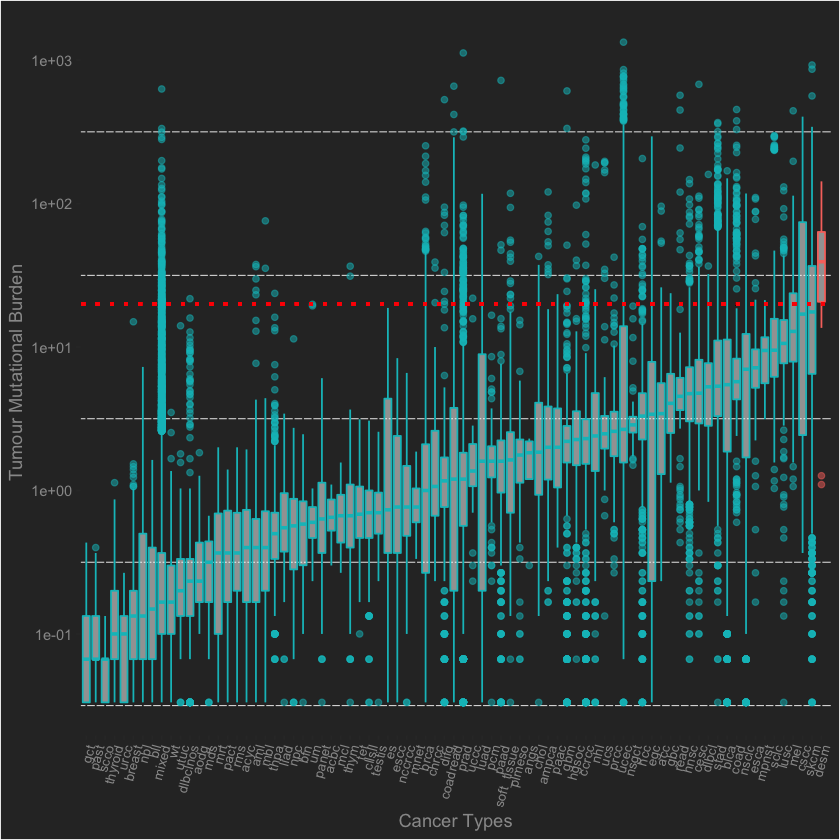

In [496]:
tmb_table %>% 
    ggplot(aes(x = cancer_type, y = TMB, colour = median < 20)) + geom_boxplot(alpha = 0.5) + scale_y_log10() +
    theme(axis.text.x = element_text(angle = 75, hjust = 1, size = 8, colour = "grey60"), axis.text.y = element_text(colour = "grey60")) + geom_segment(aes(x = 0.5, 
    y = 20, xend = 80, yend = 20), colour = "red", linetype = "dotted", size = 1) + 
    theme(panel.background = element_rect(fill = 'grey18'), panel.grid.major = element_line(colour = "grey18"), legend.position = "none")+
    theme(axis.title.x = element_text(colour = "grey60"), axis.title.y = element_text(colour = "grey60")) + labs(x = "Cancer Types", y = "Tumour Mutational Burden") +
    theme(plot.background = element_rect(fill = 'grey18'))
    

## Utilising maftools package

I wrote the below code in order to understand the Bioconductor package maftools. I wanted to able to be sure I could recaptiulate TMB estimates from tools in the package 'from first principles' (i.e. getting in and dirty with the annnotated file).

In [274]:
BiocManager::install("TCGAWorkflow", version = "3.8")
library(maftools)

Bioconductor version 3.8 (BiocManager 1.30.3), R 3.5.1 (2018-07-02)
Installing package(s) 'TCGAWorkflow'
installing the source package ‘TCGAWorkflow’

Warning message in install.packages(pkgs = doing, lib = lib, repos = repos, ...):
“installation of package ‘TCGAWorkflow’ had non-zero exit status”Update old packages: 'BiocManager', 'foreign', 'lattice', 'MASS', 'Matrix',
  'mgcv', 'survival'


In [301]:
new_data_maf <- read.maf("/Volumes/CCG8/processed_data/brca_tcga/data_mutations_extended.txt")

reading maf..
NOTE: Removed 3485 duplicated variants
silent variants: 25109


               ID     N
 1:       Samples   979
 2:       3'Flank   220
 3:         3'UTR   886
 4:       5'Flank   243
 5:         5'UTR   366
 6:           IGR     5
 7:        Intron  2570
 8:           RNA  2064
 9:        Silent 18151
10: Splice_Region   604


Summarizing..
Mutiple centers found.


[1] "genome.wustl.edu;genome.wustl.eDEC1du"
                        ID                               summary   Mean Median
 1:             NCBI_Build                                GRCh37     NA     NA
 2:                 Center genome.wustl.edu;genome.wustl.eDEC1du     NA     NA
 3:                Samples                                   982     NA     NA
 4:                 nGenes                                 15480     NA     NA
 5:        Frame_Shift_Del                                  2906  2.962      1
 6:        Frame_Shift_Ins                                  2356  2.402      1
 7:           In_Frame_Del                                   579  0.590      0
 8:           In_Frame_Ins                                   147  0.150      0
 9:      Missense_Mutation                                 50294 51.268     23
10:      Nonsense_Mutation                                  4132  4.212      2
11:       Nonstop_Mutation                                    70  0.071      0
12:     

Gene Summary..


       Hugo_Symbol Frame_Shift_Del Frame_Shift_Ins In_Frame_Del In_Frame_Ins
    1:      PIK3CA               0               2            4            1
    2:        TP53              41              13            5            0
    3:         TTN              10               1            2            1
    4:        CDH1              24              30            0            1
    5:       GATA3              17              51            0            0
   ---                                                                      
15476:     ZSCAN30               0               0            0            0
15477:      ZSWIM1               0               0            0            0
15478:        ZW10               0               0            0            0
15479:        ZXDA               0               0            0            0
15480:         ZYX               0               0            0            0
       Missense_Mutation Nonsense_Mutation Nonstop_Mutation Splice_Site
    

NOTE: Possible FLAGS among top ten genes:


[1] "TTN"   "MUC16"


Checking clinical data..
NOTE: Missing clinical data! It is strongly recommended to provide clinical data associated with samples if available.
Done !


In [302]:
new_data_tib <- read_tsv("/Volumes/CCG8/processed_data/brca_tcga/data_mutations_extended.txt")

Warning message:
“Missing column names filled in: 'X54' [54]”Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  stop_WU = col_integer(),
  X54 = col_double(),
  tumor_vaf = col_double(),
  normal_ref_reads = col_integer(),
  start_WU = col_integer(),
  strand_WU = col_integer(),
  tumors_var_reads = col_integer(),
  normal_vaf = col_double(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3282 parsing failures.
row # A tibble: 5 x 5 col     row col     expected  actual file                                         

In [383]:
maf_tmb_breakdown <- getSampleSummary(new_data_maf)
maf_tmb_breakdown

Tumor_Sample_Barcode,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,Translation_Start_Site,total
TCGA-AN-A046-01,5,21,1,0,3621,635,3,69,0,4355
TCGA-AC-A23H-01,14,4,0,0,3040,343,6,62,8,3477
TCGA-A8-A0A6-01,3,2,0,0,2001,3,1,41,0,2051
TCGA-A2-A0T5-01,2,2,0,0,1009,1,0,66,1,1081
TCGA-BH-A18G-01,165,56,10,1,758,40,1,26,2,1059
TCGA-A8-A09Z-01,130,49,24,2,729,37,3,28,2,1004
TCGA-AN-A0AK-01,197,56,38,4,572,36,0,20,1,924
TCGA-D8-A27G-01,1,4,0,0,635,72,2,8,3,725
TCGA-D8-A1XK-01,81,17,2,0,579,10,1,27,0,717
TCGA-D8-A1JA-01,6,0,3,1,604,62,0,11,1,688


In [514]:
tib_tmb_breakdown <- new_data_tib %>% 
    select(Hugo_Symbol, Chromosome, one_of(c('Start_Position','Start_position')), one_of(c('End_Position','End_position')), Strand, Variant_Classification, Variant_Type, Reference_Allele, Tumor_Seq_Allele1, Tumor_Seq_Allele2, Tumor_Sample_Barcode, Score) %>% 
    distinct() %>% 
    group_by(Tumor_Sample_Barcode, Variant_Classification) %>% 
    summarise(n = n())  %>% 
    spread(key = Variant_Classification, value = n, fill = 0) %>% 
    select(Tumor_Sample_Barcode, Frame_Shift_Del, Frame_Shift_Ins, In_Frame_Del, In_Frame_Ins, Missense_Mutation, Nonsense_Mutation, Nonstop_Mutation, Splice_Site, Translation_Start_Site) %>% 
    ungroup() %>% 
    mutate(total1 = rowSums(select(.,2:dim(.)[2])))

tib_tmb_breakdown

Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

Tumor_Sample_Barcode,Frame_Shift_Del,Frame_Shift_Ins,In_Frame_Del,In_Frame_Ins,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,Translation_Start_Site,total1
TCGA-A1-A0SB-01,3,1,0,0,12,0,0,0,0,16
TCGA-A1-A0SD-01,0,2,1,0,21,0,0,0,0,24
TCGA-A1-A0SE-01,0,0,1,0,15,2,0,0,0,18
TCGA-A1-A0SF-01,2,0,1,0,28,1,0,1,0,33
TCGA-A1-A0SG-01,3,1,0,0,20,1,0,1,0,26
TCGA-A1-A0SH-01,2,0,2,0,61,6,0,1,0,72
TCGA-A1-A0SI-01,2,0,1,0,113,14,0,6,0,136
TCGA-A1-A0SJ-01,2,0,0,0,21,2,0,0,0,25
TCGA-A1-A0SK-01,3,2,2,0,78,3,0,1,0,89
TCGA-A1-A0SM-01,4,3,1,0,11,2,0,0,0,21


So with the fiddling about above I managed to establish exactly what maf's sample summary does. It gets rid of all mutation types other than:
-  Frameshift Deletions
-  Frameshift Insertons	
-  In-Frame Deletions
-  In-Frame Insertions	
-  Missense Mutations	
-  Nonsense Mutations	
-  Nonstop Mutations
-  Splice Sites	
-  Translation Start Sites

Note that this means there may be samples from the original file that don't appear in maftools' sample summary, if they don't contain any of the required mutation types.

Maf also throws away a lot of data before searching for duplicate entries. In particular, think about whether it makes sense for two mutations of exactly the same form to occur at the same locus in the same tissue sample, with differing statistics in any other field. The data most likely to cause an issue here are "normal_ref_reads", "t_ref_count", "tumor_vaf", "tumor_ref_reads", "matched_norm_sample_barcode".

The two tables above, corresponding to maftools' sample summary and mine, are identical.

In [498]:
new_data <- read.maf(paste0(path_name, "/brca_tcga/data_mutations_extended.txt"))

reading maf..
NOTE: Removed 3485 duplicated variants
silent variants: 25109


               ID     N
 1:       Samples   979
 2:       3'Flank   220
 3:         3'UTR   886
 4:       5'Flank   243
 5:         5'UTR   366
 6:           IGR     5
 7:        Intron  2570
 8:           RNA  2064
 9:        Silent 18151
10: Splice_Region   604


Summarizing..
Mutiple centers found.


[1] "genome.wustl.edu;genome.wustl.eDEC1du"
                        ID                               summary   Mean Median
 1:             NCBI_Build                                GRCh37     NA     NA
 2:                 Center genome.wustl.edu;genome.wustl.eDEC1du     NA     NA
 3:                Samples                                   982     NA     NA
 4:                 nGenes                                 15480     NA     NA
 5:        Frame_Shift_Del                                  2906  2.962      1
 6:        Frame_Shift_Ins                                  2356  2.402      1
 7:           In_Frame_Del                                   579  0.590      0
 8:           In_Frame_Ins                                   147  0.150      0
 9:      Missense_Mutation                                 50294 51.268     23
10:      Nonsense_Mutation                                  4132  4.212      2
11:       Nonstop_Mutation                                    70  0.071      0
12:     

Gene Summary..


       Hugo_Symbol Frame_Shift_Del Frame_Shift_Ins In_Frame_Del In_Frame_Ins
    1:      PIK3CA               0               2            4            1
    2:        TP53              41              13            5            0
    3:         TTN              10               1            2            1
    4:        CDH1              24              30            0            1
    5:       GATA3              17              51            0            0
   ---                                                                      
15476:     ZSCAN30               0               0            0            0
15477:      ZSWIM1               0               0            0            0
15478:        ZW10               0               0            0            0
15479:        ZXDA               0               0            0            0
15480:         ZYX               0               0            0            0
       Missense_Mutation Nonsense_Mutation Nonstop_Mutation Splice_Site
    

NOTE: Possible FLAGS among top ten genes:


[1] "TTN"   "MUC16"


Checking clinical data..
NOTE: Missing clinical data! It is strongly recommended to provide clinical data associated with samples if available.
Done !


silent variants: 1351


              ID   N
1:       Samples   1
2:        Silent 963
3:           RNA  96
4:        Intron 157
5:       5'Flank   8
6: Splice_Region  46
7:       3'Flank   9
8:         3'UTR  49
9:         5'UTR  23


Summarizing..


                   ID          summary Mean Median
 1:        NCBI_Build           GRCh37   NA     NA
 2:            Center genome.wustl.edu   NA     NA
 3:           Samples                1   NA     NA
 4:            nGenes             3340   NA     NA
 5:   Frame_Shift_Del                5    5      5
 6:   Frame_Shift_Ins               21   21     21
 7:      In_Frame_Del                1    1      1
 8: Missense_Mutation             3621 3621   3621
 9: Nonsense_Mutation              635  635    635
10:  Nonstop_Mutation                3    3      3
11:       Splice_Site               69   69     69
12:             total             4355 4355   4355


Gene Summary..


      Hugo_Symbol Frame_Shift_Del Frame_Shift_Ins In_Frame_Del
   1:         TTN               0               0            0
   2:       SYNE1               0               0            0
   3:       CMYA5               0               0            0
   4:       HMCN1               0               0            0
   5:       MUC16               0               0            0
  ---                                                         
3336:      ZSWIM6               0               0            0
3337:       ZUFSP               0               0            0
3338:        ZXDC               0               0            0
3339:      ZYG11B               0               0            0
3340:       ZZEF1               0               0            0
      Missense_Mutation Nonsense_Mutation Nonstop_Mutation Splice_Site total
   1:                24                 1                0           0    25
   2:                 8                 1                0           0     9
   3:        

NOTE: Possible FLAGS among top ten genes:


[1] "TTN"   "SYNE1" "HMCN1" "MUC16" "DST"  


Checking clinical data..
NOTE: Missing clinical data! It is strongly recommended to provide clinical data associated with samples if available.
Done !
Processing TCGA-AN-A046-01..
Kataegis detected at:


   Chromosome Start_Position End_Position nMuts Avg_intermutation_dist Size
1:          5       79033484     79034948     5                 366.00 1464
2:         13       46543420     46544101     5                 170.25  681
   Tumor_Sample_Barcode C>A C>T T>G
1:      TCGA-AN-A046-01   2   2   1
2:      TCGA-AN-A046-01   3   1   1


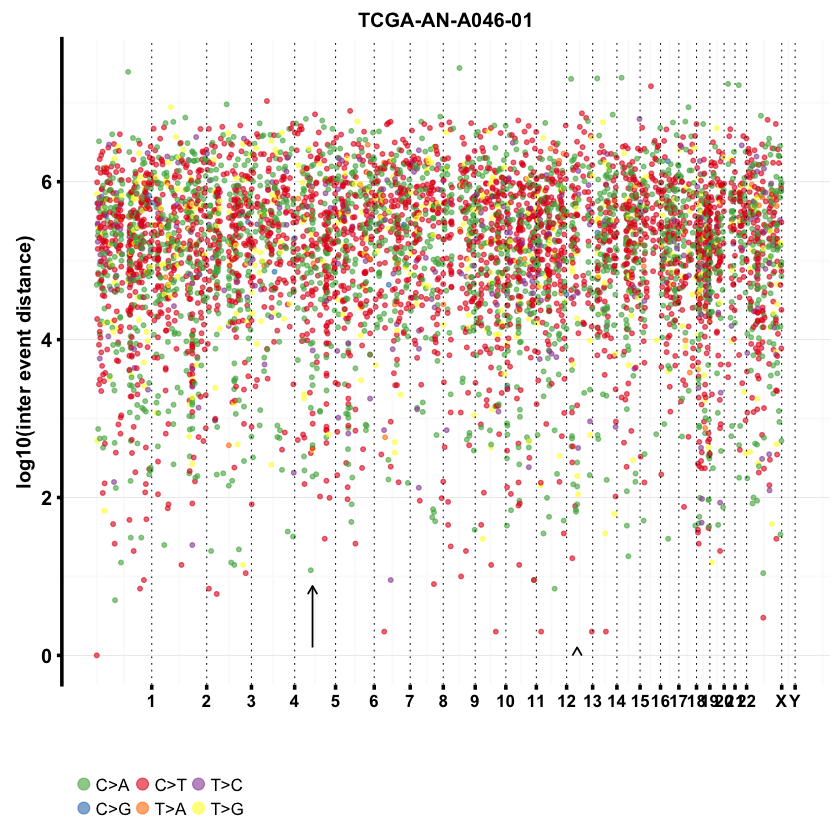

In [512]:
new_data %>% 
    subsetMaf(tsb = "TCGA-AN-A046-01") %>% 
    read.maf() %>% 
    rainfallPlot(detectChangePoints = TRUE)